In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report, roc_curve)

In [6]:
df = pd.read_csv('../data/processed/model_dataset.csv')

In [7]:
df.head()

,water_density,water_per_lga,log_popdensity,NEAR_DIST_Water,NEAR_DIST_Health,population,Has_Outbreak,lgaarea,lganame,statename,Case
0,4.657624,19,5.493968,222.811186,1612.70446,38295.61355,0,158.102371,Eastern Obolo,Akwa Ibom,0.0
1,4.657624,19,5.493968,222.811186,1612.70446,38295.61355,0,158.102371,Eastern Obolo,Akwa Ibom,0.0
2,4.657624,19,5.493968,222.811186,1612.70446,38295.61355,0,158.102371,Eastern Obolo,Akwa Ibom,0.0
3,4.657624,19,5.493968,222.811186,1612.70446,38295.61355,0,158.102371,Eastern Obolo,Akwa Ibom,0.0
4,4.657624,19,5.493968,222.811186,1612.70446,38295.61355,0,158.102371,Eastern Obolo,Akwa Ibom,0.0


## Handling Imbalanced Class

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
X = df.drop(['Has_Outbreak', 'Case', 'lganame', 'statename'], axis=1)
y = df['Has_Outbreak']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [11]:
y_train.value_counts(normalize=True)

Has_Outbreak
0    0.960843
1    0.039157
Name: proportion, dtype: float64

In [12]:
X_train.shape

(2324, 7)

In [13]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [14]:
y_train_balanced.value_counts(normalize=True)

Has_Outbreak
0    0.5
1    0.5
Name: proportion, dtype: float64

In [15]:
X_train_balanced.head()

,water_density,water_per_lga,log_popdensity,NEAR_DIST_Water,NEAR_DIST_Health,population,lgaarea
0,3.294523,4,6.491138,8358.110764,968.911491,678617.2065,1030.905396
1,6.722830,152,5.461619,3230.392293,2713.516407,317629.2750,1354.620850
2,3.230538,4,6.073312,12126.435937,4934.703809,604337.1252,1395.323364
3,2.034037,1,6.644887,7697.067766,1492.714903,281624.3768,366.773224
4,4.150937,13,4.807192,12646.760377,3495.486692,223851.4968,1844.106934


## (Base Model)

In [16]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [17]:
classifier.fit(X_train_balanced, y_train_balanced)
feat_imp_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': classifier.feature_importances_})
top_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(2)['Feature'].tolist()

In [18]:
feat_imp_df

,Feature,Importance
0,water_density,0.217501
1,water_per_lga,0.141211
2,log_popdensity,0.108571
3,NEAR_DIST_Water,0.130951
4,NEAR_DIST_Health,0.098481
5,population,0.190426
6,lgaarea,0.112859


In [19]:
def evaluate_model(classifier, X_data, y_true, dataset_name):
    y_pred = classifier.predict(X_data)
    y_proba = classifier.predict_proba(X_data)[:, 1]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)

    print(f"\n Evaluation on {dataset_name} Set")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"ROC AUC:   {roc_auc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    fig_cm, ax_cm = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                xticklabels=["Safe", "Outbreak"],
                yticklabels=["Safe", "Outbreak"])
    ax_cm.set_title(f"{dataset_name} - Confusion Matrix")
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("Actual")
    plt.show()

    # Classification Report
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, digits=3))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    fig_roc, ax_roc = plt.subplots()
    ax_roc.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax_roc.plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"{dataset_name} - ROC Curve")
    ax_roc.legend()
    ax_roc.grid(True)
    plt.show()

Evaluating RandomForestClassifier:

 Evaluation on Validation Set
Accuracy:  0.937
Precision: 0.172
Recall:    0.167
F1 Score:  0.169
ROC AUC:   0.719


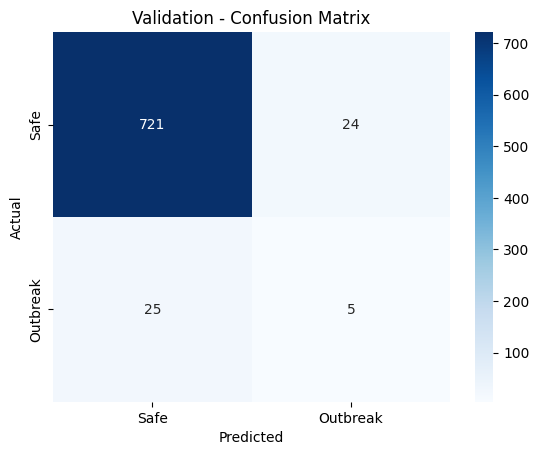


 Classification Report:
              precision    recall  f1-score   support

           0      0.966     0.968     0.967       745
           1      0.172     0.167     0.169        30

    accuracy                          0.937       775
   macro avg      0.569     0.567     0.568       775
weighted avg      0.936     0.937     0.936       775



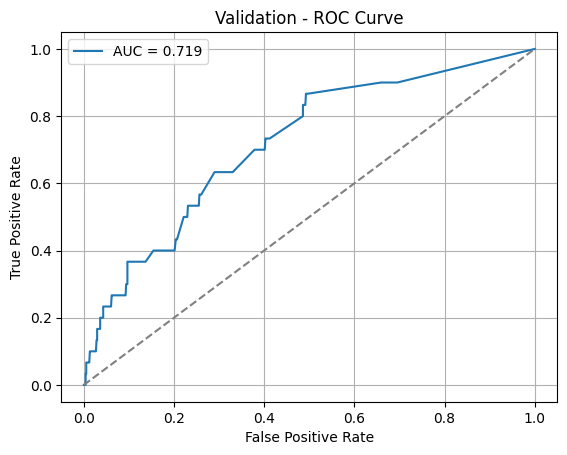


 Evaluation on Test Set
Accuracy:  0.934
Precision: 0.080
Recall:    0.067
F1 Score:  0.073
ROC AUC:   0.531


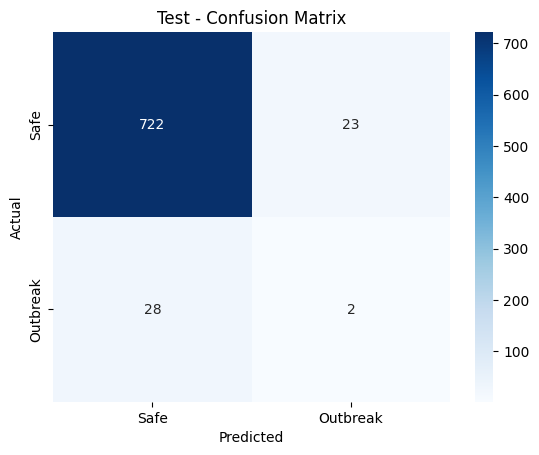


 Classification Report:
              precision    recall  f1-score   support

           0      0.963     0.969     0.966       745
           1      0.080     0.067     0.073        30

    accuracy                          0.934       775
   macro avg      0.521     0.518     0.519       775
weighted avg      0.928     0.934     0.931       775



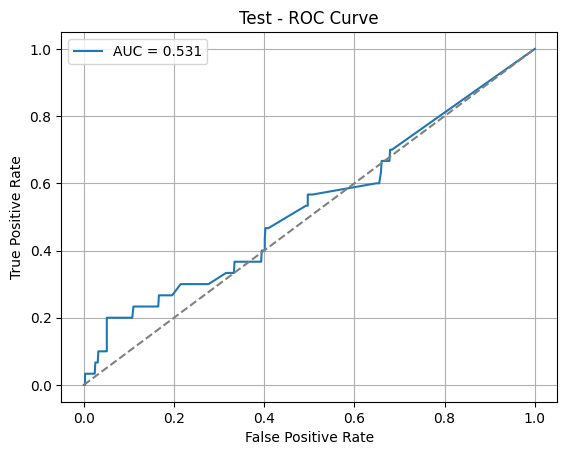

In [20]:
print("Evaluating RandomForestClassifier:")
evaluate_model(classifier, X_val, y_val, "Validation")
evaluate_model(classifier, X_test, y_test, "Test")

## Model

In [21]:
model = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=7, min_samples_leaf=5, random_state=42)

In [22]:
model.fit(X_train_balanced, y_train_balanced)

,n_estimators,200
,criterion,'entropy'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# params = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': np.arange(1,8,1),
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [5,10,20,50,100,200]
# }

In [24]:
# grid_search_rf = GridSearchCV(estimator=model,
#                            param_grid=params,
#                            cv = 5,
#                            n_jobs=-1, verbose=1, scoring="accuracy")

In [25]:
# grid_search_rf.fit(X_train_balanced, y_train_balanced)

In [26]:
# rf_best = grid_search_rf.best_estimator_


 Evaluation on Validation Set
Accuracy:  0.836
Precision: 0.085
Recall:    0.333
F1 Score:  0.136
ROC AUC:   0.675


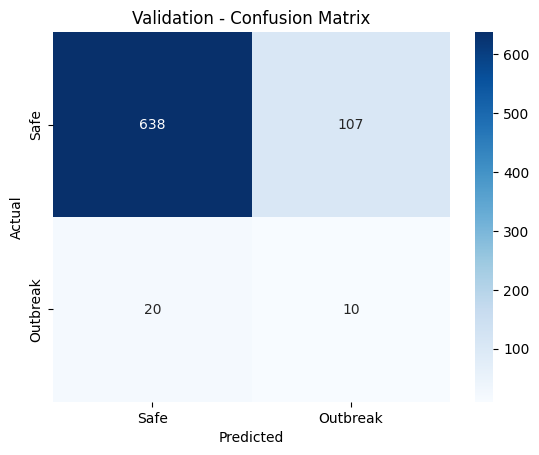


 Classification Report:
              precision    recall  f1-score   support

           0      0.970     0.856     0.909       745
           1      0.085     0.333     0.136        30

    accuracy                          0.836       775
   macro avg      0.528     0.595     0.523       775
weighted avg      0.935     0.836     0.880       775



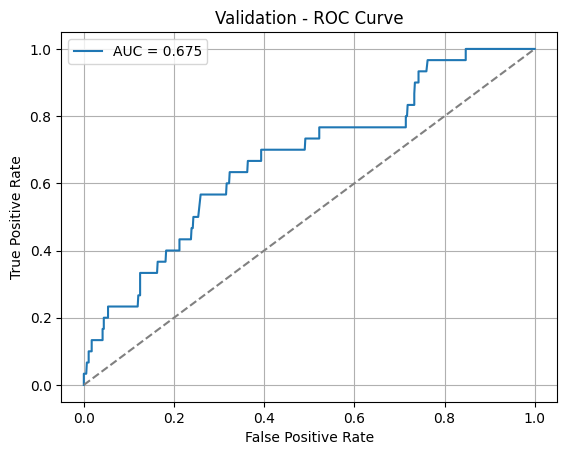


 Evaluation on Test Set
Accuracy:  0.822
Precision: 0.065
Recall:    0.267
F1 Score:  0.104
ROC AUC:   0.669


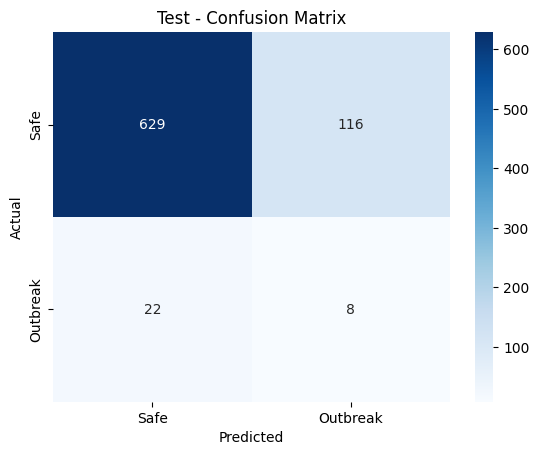


 Classification Report:
              precision    recall  f1-score   support

           0      0.966     0.844     0.901       745
           1      0.065     0.267     0.104        30

    accuracy                          0.822       775
   macro avg      0.515     0.555     0.503       775
weighted avg      0.931     0.822     0.870       775



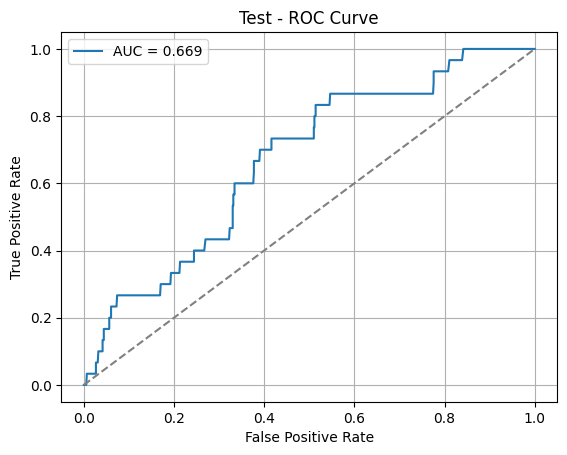

In [27]:
evaluate_model(model, X_val, y_val, "Validation")
evaluate_model(model, X_test, y_test, "Test")

In [28]:
pd.set_option('display.max_rows', None)

In [29]:
y_prob = model.predict_proba(X_test)[:, 1]

new_threshold = 0.2
y_pred_new = (y_prob >= new_threshold).astype(int)

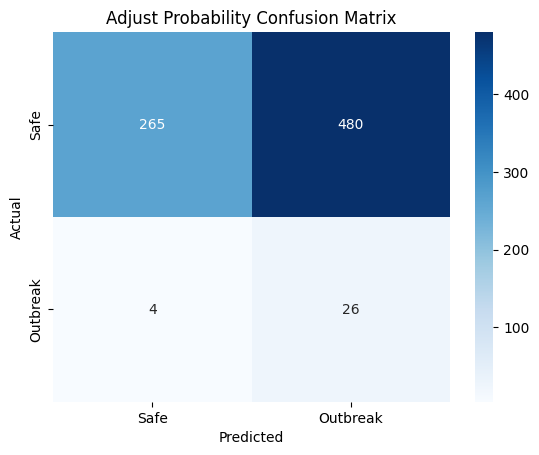

              precision    recall  f1-score   support

           0      0.985     0.356     0.523       745
           1      0.051     0.867     0.097        30

    accuracy                          0.375       775
   macro avg      0.518     0.611     0.310       775
weighted avg      0.949     0.375     0.506       775



In [30]:
adj_cm = confusion_matrix(y_test, y_pred_new)
fig_cm, ax_cm = plt.subplots()
sns.heatmap(adj_cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                xticklabels=["Safe", "Outbreak"],
                yticklabels=["Safe", "Outbreak"])
ax_cm.set_title(f"Adjust Probability Confusion Matrix")
ax_cm.set_xlabel("Predicted")
ax_cm.set_ylabel("Actual")
plt.show()
print(classification_report(y_test, y_pred_new, digits=3))

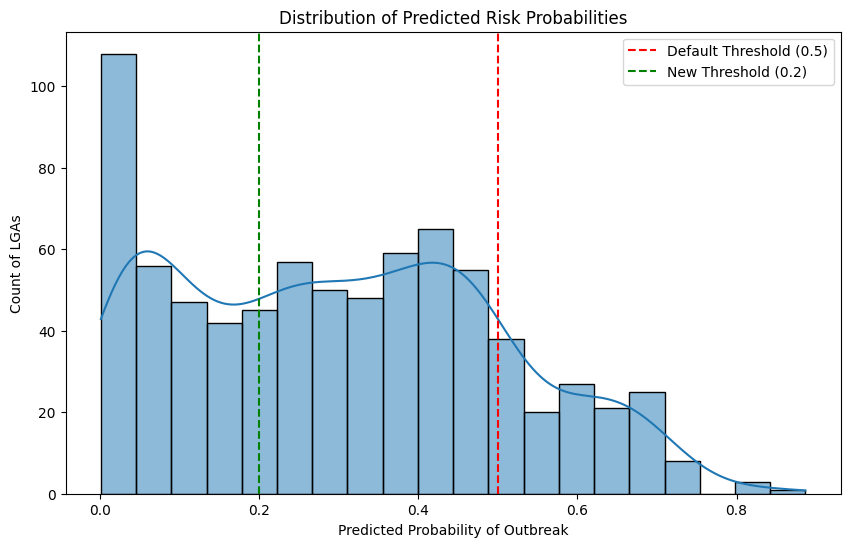

In [31]:
# Plot the distribution of probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_prob, bins=20, kde=True)
plt.axvline(0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
plt.axvline(0.2, color='green', linestyle='--', label='New Threshold (0.2)')
plt.title('Distribution of Predicted Risk Probabilities')
plt.xlabel('Predicted Probability of Outbreak')
plt.ylabel('Count of LGAs')
plt.legend()
plt.show()

### Saving ML Model

In [32]:
import pickle


In [33]:
filename = 'cholera_rf_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)
print(f"Model saved to {filename}")

Model saved to cholera_rf_model.pkl


## Vulnerability Index

In [34]:
names_df = df.loc[X_test.index, ['lganame', 'statename']]


In [35]:
results = names_df.copy() 
results['Actual_Status'] = y_test
results['Predicted_Risk'] = y_pred_new
results['Risk_Probability'] = y_prob 

In [36]:
silent_risk_zones = results[
    (results['Actual_Status'] == 0) &
    (results['Predicted_Risk'] == 1)
].sort_values(by='Risk_Probability', ascending=False)

In [37]:
print(f"Identified {len(silent_risk_zones)} Silent Risk Zones.")
print("Top 10 Highest Risk Areas without current outbreaks:")
display(silent_risk_zones.head(10))

Identified 480 Silent Risk Zones.
Top 10 Highest Risk Areas without current outbreaks:


,lganame,statename,Actual_Status,Predicted_Risk,Risk_Probability
422,Yenegoa,Bayelsa,0,1,0.886526
3763,Eti Osa,Lagos,0,1,0.818290
3766,Eti Osa,Lagos,0,1,0.818290
1268,Talata Mafara,Zamfara,0,1,0.817517
79,Nembe,Bayelsa,0,1,0.735286
14,Degema,Rivers,0,1,0.729387
2180,Kogi,Kogi,0,1,0.722977
174,Akuku Toru,Rivers,0,1,0.715309
769,Bauchi,Bauchi,0,1,0.713021
767,Bauchi,Bauchi,0,1,0.713021


In [38]:
silent_risk_zones = silent_risk_zones.fillna(0)

In [39]:
def assign_tier(prob):
    if prob >= 0.50: return "Tier 1: Critical (Immediate Action)"
    elif prob >= 0.35: return "Tier 2: High (Priority Monitoring)"
    elif prob >= 0.20: return "Tier 3: Moderate (Surveillance)"
    else: return "Low"

In [40]:
silent_risk_zones['Risk_Tier'] = silent_risk_zones['Risk_Probability'].apply(assign_tier)

In [41]:
silent_risk_zones['Risk_Tier'].value_counts()

Risk_Tier
Tier 2: High (Priority Monitoring)     188
Tier 3: Moderate (Surveillance)        176
Tier 1: Critical (Immediate Action)    116
Name: count, dtype: int64

In [42]:
final_export = silent_risk_zones.copy()

In [43]:
final_export = final_export.rename(columns={
    'Risk_Probability': 'Risk_Prob', 
    'Risk_Tier': 'Tier'
})

In [45]:
final_export.to_csv("../results/Final_Tiered_Risk_Output.csv", index=False)

In [46]:
actual_risk_zones = results[
    (results['Actual_Status'] == 1) &
    (results['Predicted_Risk'] == 1)
].sort_values(by='Risk_Probability', ascending=False)

In [47]:
print(f"Identified {len(actual_risk_zones)} Actual Risk Zones.")
print("Top 10 Highest Risk Areas with current outbreaks:")
display(actual_risk_zones.head(10))

Identified 26 Actual Risk Zones.
Top 10 Highest Risk Areas with current outbreaks:


,lganame,statename,Actual_Status,Predicted_Risk,Risk_Probability
75,Nembe,Bayelsa,1,1,0.735286
46,Southern Ijaw,Bayelsa,1,1,0.683118
8,Ekeremor,Bayelsa,1,1,0.678716
311,Ogbia,Bayelsa,1,1,0.667063
378,Gummi,Zamfara,1,1,0.664159
85,Brass,Bayelsa,1,1,0.640183
3109,Etung,Cross River,1,1,0.634293
1255,Kaita,Katsina,1,1,0.617603
518,Edu,Kwara,1,1,0.489384
1748,Kolokuma/Opokuma,Bayelsa,1,1,0.479097


In [48]:
actual_risk_zones = actual_risk_zones.fillna(0)

In [50]:
actual_risk_zones.to_csv('../results/actual_risk_zones.csv', index=False)